In [1]:
import os
import json
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
match_data_path = "../data/match_data.json"
replay_data_path = "../data/processed_replays/"

match_data_df = pd.read_json(match_data_path)
match_files = [os.path.join(replay_data_path, f) for f in os.listdir(replay_data_path)]

In [4]:
hero2idx_path = "../data/hero_to_idx.json"
item2idx_path = "../data/item_to_idx.json"

if not os.path.exists(hero2idx_path) or not os.path.exists(item2idx_path):
    max_seq_len = 0
    hero_set = set()
    item_set = set()

    for match in match_files:
        with open(match, 'r') as f:
            match_data = json.load(f)
        seq_len = len(match_data)
        if seq_len > max_seq_len:
            max_seq_len = seq_len
        for ts in match_data:
            for team in ('radiant', 'dire'):
                for player in match_data[ts][team]['players']:
                    hero_set.add(player['heroId'])
                    inv = [item['id'] for item in player['inventory']]
                    item_set.update([item['id'] for item in player['inventory']])

    hero_to_idx = {hid: idx for idx, hid in enumerate(sorted(hero_set))}
    item_to_idx = {'<PAD>': 0}
    for idx, name in enumerate(sorted(item_set), start=1):
        item_to_idx[name] = idx

    with open(hero2idx_path, "w") as hero_file:
        json.dump(hero_to_idx, hero_file)
    with open(item2idx_path, "w") as item_file:
        json.dump(item_to_idx, item_file)
else:
    max_seq_len = 123
    with open(hero2idx_path, "r") as hero_file:
        hero_to_idx = json.load(hero_file)
    with open(item2idx_path, "r") as item_file:
        item_to_idx = json.load(item_file)

print(f"Max sequence length: {max_seq_len}")

Max sequence length: 123


### Define Dataset Class

In [5]:
def encode_timeslice(state, hero_to_idx, item_to_idx):
    """
    Encode a single timeslice state into 1-D representation: (hero_ids, item_ids, player_numeric, team_numeric)
    """
    hero_ids = []
    item_ids = []
    player_numeric = []
    player_num_keys = [
        "level","xp","networth","totalGold","currentGold","lifeState",
        "respawnSeconds","buybackCooldown","heroDamage","towerDamage",
        "damageTakenPostReduction","kills","deaths","assists","lastHits",
        "denies","teamfightParticipation","obsPlaced","senPlaced"
    ]

    for team in ("radiant", "dire"):
        for player in state[team]["players"]:
            hero_ids.append(hero_to_idx[str(player["heroId"])])
            inv_ids = []
            for slot in range(6):
                if slot < len(player["inventory"]):
                    item_name = player["inventory"][slot].get("id")
                    inv_ids.append(item_to_idx.get(item_name, item_to_idx["<PAD>"]))
                else:
                    inv_ids.append(item_to_idx["<PAD>"])
            item_ids.append(inv_ids)
            numeric_vals = [player[key] for key in player_num_keys]
            player_numeric.append(numeric_vals)

    team_numeric = []
    team_num_keys = [
        "totalCampsStacked","totalRunePickups","totalTowersKilled","totalRoshansKilled",
        "totalSmokesUsed","numWards","pdistMean","pdistMax","pdistStd",
        "centroidWardMean","hwMean","hwMin","hwMax"
    ]
    building_keys = state["radiant"]["buildings"].keys()

    for team in ("radiant", "dire"):
        buildings = [state[team]["buildings"][bk]["health"] for bk in building_keys]
        other = [state[team].get(k, 0) for k in team_num_keys]
        team_numeric.append(buildings + other)

    player_numeric = torch.tensor(player_numeric, dtype=torch.float32)
    team_numeric = torch.tensor(team_numeric, dtype=torch.float32)
    player_numeric = torch.log1p(player_numeric)
    team_numeric = torch.log1p(team_numeric)

    return hero_ids, item_ids, player_numeric, team_numeric

In [6]:
class NextSliceDataset(Dataset):
    """
    Dataset for next-slice prediction. Provides sliding windows of timeslices.
    """
    def __init__(self, matches_dir, match_data, hero_to_idx, item_to_idx, window_size=20):
        self.window_size = window_size
        self.hero_to_idx = hero_to_idx
        self.item_to_idx = item_to_idx
        self.match_data = match_data
        self.matches_dir = matches_dir
        self.match_ids = [int(f.split("/")[-1].split(".")[0]) for f in os.listdir(matches_dir)]
        self.windows = []

        for match_id in self.match_ids:
            with open(os.path.join(matches_dir, f"{match_id}.json"), 'r') as f:
                data = json.load(f)
            num_slices = len(data)
            if num_slices < window_size:
                print(f"Match {match_id} has only {num_slices} slices, less than window size {window_size}.")
                continue
            md = self.match_data
            outcome_label = md.loc[md["match_id"] == match_id]["radiant_win"].astype(int).values[0]
            for start in range(num_slices - window_size):
                self.windows.append((match_id, start, outcome_label))
    
    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        match_id, start, label = self.windows[idx]
        fpath = os.path.join(self.matches_dir, f"{match_id}.json")
        with open(fpath, 'r') as f:
            data = json.load(f)
        time_keys = list(data.keys())
        hero_w, item_w, pnum_w, tnum_w = [], [], [], []
        for offset in range(self.window_size + 1):
            state = data[time_keys[start + offset]]
            h, it, pnum, tnum = encode_timeslice(state, self.hero_to_idx, self.item_to_idx)
            if offset < self.window_size:
                hero_w.append(h)
                item_w.append(it)
                pnum_w.append(pnum)
                tnum_w.append(tnum)
            else:
                pnum_tgt, tnum_tgt = pnum, tnum

        hero_window = torch.tensor(hero_w, dtype=torch.long)
        item_window = torch.tensor(item_w, dtype=torch.long)
        player_num_window = torch.stack(pnum_w).float()
        team_num_window = torch.stack(tnum_w).float()

        target_numeric = torch.cat([pnum_tgt.view(-1), tnum_tgt.view(-1)])
        return hero_window, item_window, player_num_window, team_num_window, target_numeric, label

In [7]:
class OutcomeDataset(Dataset):
    """
    Dataset for win/lose classification. Uses the last window of each match.
    """
    def __init__(self, next_slice_dataset: NextSliceDataset):
        self.dataset = next_slice_dataset
        self.indices = []
        max_start = {}
        for idx, (match_id, start, _) in enumerate(self.dataset.windows):
            max_start[match_id] = max(max_start.get(match_id, -1), start)

        for idx, (match_id, start, label) in enumerate(self.dataset.windows):
            if start == max_start[match_id]:
                self.indices.append(idx)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        win_idx = self.indices[idx]
        hero_w, item_w, pnum_w, tnum_w, _, label = self.dataset[win_idx]
        return hero_w, item_w, pnum_w, tnum_w, torch.tensor(label, dtype=torch.long)

### Train Models

In [1]:
from tqdm import tqdm

from models import TimesliceTransformer, OutcomeMLP

#### Pretrain

In [11]:
window_size = 20
batch_size = 256
epochs = 10
lr = 1e-4

In [12]:
ds = NextSliceDataset(
    matches_dir=replay_data_path,
    match_data=match_data_df,
    hero_to_idx=hero_to_idx,
    item_to_idx=item_to_idx,
    window_size=window_size
)

In [17]:
val_split = 0.15
val_size = int(len(ds) * val_split)
train_size = len(ds) - val_size
train_ds, val_ds = random_split(ds, [train_size, val_size])

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, pin_memory=True
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [13]:
model = TimesliceTransformer(
    hero_vocab_size=len(hero_to_idx),
    item_vocab_size=len(item_to_idx),
    max_seq_len=max_seq_len,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
model

TimesliceTransformer(
  (hero_emb): Embedding(125, 16)
  (item_emb): Embedding(326, 8, padding_idx=0)
  (input_proj): Linear(in_features=892, out_features=512, bias=True)
  (input_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
 

In [17]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters:     42,650,364
Trainable parameters: 42,650,364


In [18]:
os.makedirs("../weights/", exist_ok=True)

In [ ]:
train_losses, val_losses = [], []

In [25]:
for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Train Epoch {epoch}/{epochs}", leave=False)
    for hero_w, item_w, pnum_w, tnum_w, target, _ in loop:
        hero_w = hero_w.to(device)
        item_w = item_w.to(device)
        pnum_w = pnum_w.to(device)
        tnum_w = tnum_w.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        pred = model(hero_w, item_w, pnum_w, tnum_w)
        loss = F.mse_loss(pred, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    avg_train = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for hero_w, item_w, pnum_w, tnum_w, target, _ in val_loader:
            hero_w, item_w = hero_w.to(device), item_w.to(device)
            pnum_w, tnum_w = pnum_w.to(device), tnum_w.to(device)
            target = target.to(device)
            pred = model(hero_w, item_w, pnum_w, tnum_w)
            loss = F.mse_loss(pred, target)
            val_loss += loss.item()
    avg_val = val_loss / len(val_loader)

    train_losses.append(avg_train)
    val_losses.append(avg_val)
    print(f"Epoch {epoch}/{epochs} → Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")
    torch.save(model.state_dict(), f'../weights/transformer_pretrained_{epoch}.pth')

Epoch 1/10 → Train Loss: 0.3065, Val Loss: 0.2484


Epoch 2/10 → Train Loss: 0.2655, Val Loss: 0.2270


Epoch 3/10 → Train Loss: 0.2461, Val Loss: 0.2157


Epoch 4/10 → Train Loss: 0.2339, Val Loss: 0.2093


Epoch 5/10 → Train Loss: 0.2257, Val Loss: 0.2040


Epoch 6/10 → Train Loss: 0.2191, Val Loss: 0.1991


Epoch 7/10 → Train Loss: 0.2138, Val Loss: 0.1985


Epoch 8/10 → Train Loss: 0.2096, Val Loss: 0.1948


Epoch 9/10 → Train Loss: 0.2060, Val Loss: 0.1936


Epoch 10/10 → Train Loss: 0.2030, Val Loss: 0.1932


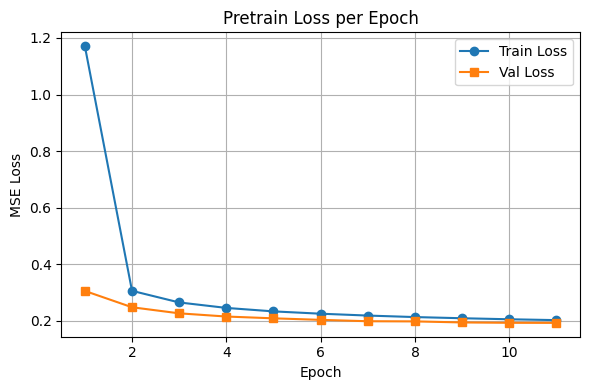

In [26]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='s', label='Val Loss')
plt.title('Pretrain Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Finetune

In [14]:
model.load_state_dict(torch.load('../weights/transformer_pretrained_10.pth', map_location=device))

<All keys matched successfully>

In [15]:
batch_size = 256
epochs = 3
lr = 1e-3

In [18]:
ds_out = OutcomeDataset(ds)
val_size = int(len(ds_out) * val_split)
train_size = len(ds_out) - val_size
train_ds, val_ds = random_split(ds_out, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

model.to(device).eval()
for p in model.parameters():
    p.requires_grad = False

mlp = OutcomeMLP(model_dim=model.input_proj.out_features, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

In [19]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, epochs+1):
    mlp.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for hero_w, item_w, pnum_w, tnum_w, label in loop:
        hero_w, item_w = hero_w.to(device), item_w.to(device)
        pnum_w, tnum_w = pnum_w.to(device), tnum_w.to(device)
        label = label.to(device)

        with torch.no_grad():
            feat = model.encode_sequence(hero_w, item_w, pnum_w, tnum_w)

        logits = mlp(feat)
        loss = F.binary_cross_entropy_with_logits(logits, label.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * label.size(0)
        
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        correct_preds += (preds == label).sum().item()
        total_samples += label.size(0)

    avg_train_loss = running_loss / total_samples
    train_acc = correct_preds / total_samples

    mlp.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for hero_w, item_w, pnum_w, tnum_w, label in val_loader:
            hero_w, item_w = hero_w.to(device), item_w.to(device)
            pnum_w, tnum_w = pnum_w.to(device), tnum_w.to(device)
            label = label.to(device)

            feat = model.encode_sequence(hero_w, item_w, pnum_w, tnum_w)
            logits = mlp(feat)
            loss = F.binary_cross_entropy_with_logits(logits, label.float())

            val_loss += loss.item() * label.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            val_correct += (preds == label).sum().item()
            val_total += label.size(0)

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{epochs} → "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.3%} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.3%}")

    torch.save(mlp.state_dict(), f'../weights/outcome_mlp_{epoch}.pth')

Epoch 1/3 → Train Loss: 0.1310, Train Acc: 96.412% | Val Loss: 0.0273, Val Acc: 98.933%


Epoch 2/3 → Train Loss: 0.0203, Train Acc: 99.362% | Val Loss: 0.0221, Val Acc: 99.111%


Epoch 3/3 → Train Loss: 0.0171, Train Acc: 99.529% | Val Loss: 0.0237, Val Acc: 98.933%


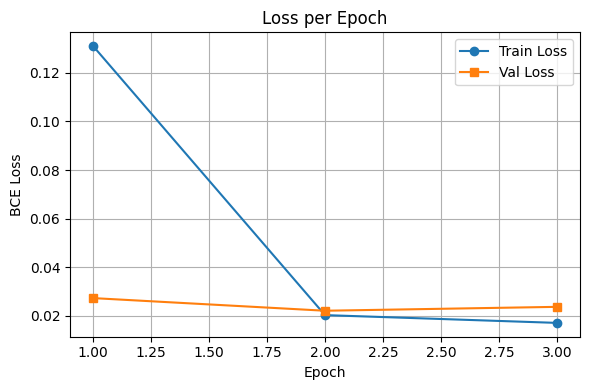

In [7]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='s', label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()